<a href="https://colab.research.google.com/github/yassine-turki/Bachelor_thesis/blob/main/Thesis_notebook_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])


trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 213108232.24it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 70509717.01it/s]


Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 84183065.70it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16185665.90it/s]


Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 149065506.11it/s]


Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103534781.05it/s]


Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34702477.26it/s]


Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1378774.61it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


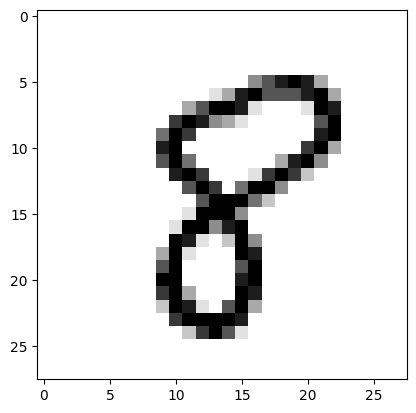

In [4]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

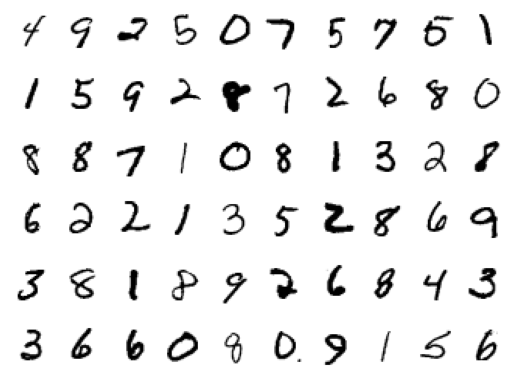

In [5]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

def create_network_dict(num_nodes_per_layer):
    network_dict = {}
    for layer in range(1, len(num_nodes_per_layer) + 1):
        layer_name = f"Layer{layer}"
        network_dict[layer_name] = {f"node{i}": [] for i in range(num_nodes_per_layer[layer - 1])}
    return network_dict

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MyModel, self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_sizes[1], output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.node_dict = create_network_dict(num_nodes_per_layer=hidden_sizes)
        self.node_dict_testing = create_network_dict(num_nodes_per_layer=hidden_sizes)
        self.testing = False

    def record_node_values(self, x, layer):
        if self.testing:
            for j in range(len(x[0])):
                self.node_dict_testing[f"Layer{layer}"][f"node{j}"].extend(x[:, j].detach().cpu().numpy())
        else:
            for j in range(len(x[0])):
                self.node_dict[f"Layer{layer}"][f"node{j}"].extend(x[:, j].detach().cpu().numpy())

    def forward(self, x):
        layer = 1
        x = self.relu1(self.layer1(x))
        self.record_node_values(x, layer)
        layer+=1
        x = self.relu2(self.layer2(x))
        self.record_node_values(x, layer)
        x = self.log_softmax(self.layer3(x))
        return x





model = MyModel(input_size, hidden_sizes, output_size)
print(model)

MyModel(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=64, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [7]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6644404921561543
Epoch 1 - Training loss: 0.2858968332513118
Epoch 2 - Training loss: 0.22112426760274845
Epoch 3 - Training loss: 0.17781211476900113
Epoch 4 - Training loss: 0.14935717160608977
Epoch 5 - Training loss: 0.12742803181046997
Epoch 6 - Training loss: 0.11160329669348594
Epoch 7 - Training loss: 0.09948634769696035
Epoch 8 - Training loss: 0.09036697354862716
Epoch 9 - Training loss: 0.08066473026890983
Epoch 10 - Training loss: 0.07404480946720886
Epoch 11 - Training loss: 0.06781949102183554
Epoch 12 - Training loss: 0.062266885241154014
Epoch 13 - Training loss: 0.05777988276942802
Epoch 14 - Training loss: 0.05236575979568652

Training Time (in minutes) = 5.066332010428111


In [9]:
def extract_node_value_ranges(model, num_nodes_per_layer):
    node_dict = model.node_dict
    interval_dict = create_network_dict(num_nodes_per_layer=num_nodes_per_layer)
    for layer, subdict in node_dict.items():
        for node, values in subdict.items():
            min_values = min(values)
            max_values = max(values)
            interval_dict[layer][node] = [min_values, max_values]
    return interval_dict

In [ ]:

#hidden_sizes = [128, 64]
percent_list = []

value_ranges = extract_node_value_ranges(model, num_nodes_per_layer = hidden_sizes)


correct_count, all_count = 0, 0
true_count = 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            model.eval()
            model.testing = True
            logps = model(img)
            for layer, subdict in model.node_dict_testing.items():
                for node, values in subdict.items():
                    min_value, max_value = value_ranges[layer][node]
                    are_values_in_interval = all(min_value <= value <= max_value for value in values)
                    true_count += are_values_in_interval

            # Calculate the percentage of True nodes 2 layers with sizes in hidden_sizes
        percentage_true = (true_count / (np.prod(hidden_sizes))) * 100
        percent_list.append(percentage_true)
        true_count = 0


    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1



print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

In [ ]:
percent_list

In [ ]:
torch.save(model, './my_mnist_model.pt')